# 1. MCLP

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
!pip install pulp
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus, value
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 11.4 MB/s eta 0:00:00


In [2]:
# 데이터 로드
li = pd.read_csv('/content/drive/MyDrive/MCLP_data/li.csv')
sights = pd.read_csv('/content/drive/MyDrive/MCLP_data/sight_0720.csv')
hotels = pd.read_csv('/content/drive/MyDrive/MCLP_data/hotel_0720.csv')
rests = pd.read_csv('/content/drive/MyDrive/MCLP_data/rests_0720.csv')
cafes = pd.read_csv('/content/drive/MyDrive/MCLP_data/cafe_0720.csv')
store = pd.read_csv('/content/drive/MyDrive/MCLP_data/store_0720.csv')
oil = pd.read_csv('/content/drive/MyDrive/MCLP_data/oil_0720.csv')
golf = pd.read_csv('/content/drive/MyDrive/MCLP_data/golf_0720.csv')
pension = pd.read_csv('/content/drive/MyDrive/MCLP_data/pension_0720.csv')
houses = pd.read_csv('/content/drive/MyDrive/MCLP_data/houses_0720.csv')
uses_houses = pd.read_csv('/content/drive/MyDrive/MCLP_data/uses_houses.csv')
sights_m = pd.read_csv('/content/drive/MyDrive/MCLP_data/sight_0720.csv')

In [3]:
li = li[['region', 'lat', 'lng']]
li = gpd.GeoDataFrame(li, geometry=gpd.points_from_xy(li.lng, li.lat))
# li.reset_index(inplace=True)
li.head()

,region,lat,lng,geometry
0,경상남도 합천군 가야면 가천리,35.754781,128.093447,POINT (128.09345 35.75478)
1,경상남도 합천군 가야면 구미리,35.742583,128.106607,POINT (128.10661 35.74258)
2,경상남도 합천군 가야면 구원리,35.787984,128.122287,POINT (128.12229 35.78798)
3,경상남도 합천군 가야면 대전리,35.733125,128.077043,POINT (128.07704 35.73312)
4,경상남도 합천군 가야면 매안리,35.727841,128.103074,POINT (128.10307 35.72784)


In [4]:
# 수요 지점 데이터 처리
#csvs = [sights, hotels, rests, cafes, store, oil, golf, pension]

csvs = [sights, rests, hotels, cafes, store, oil, golf, pension]

for i, place in enumerate(csvs):
    csvs[i] = place[['이름', 'lat', 'lng']]
    csvs[i] = gpd.GeoDataFrame(csvs[i], geometry=gpd.points_from_xy(csvs[i]['lng'], csvs[i]['lat']))
    csvs[i].crs = 'epsg:4326'
    csvs[i] = csvs[i].to_crs(epsg=5179)

In [5]:
points = pd.concat(csvs, ignore_index=True)
points['weights'] = 1  # weights 수정 필요
points = points.to_crs(epsg=5179)

In [6]:
# li 데이터 처리
li = li[['region', 'lat', 'lng']]
li = gpd.GeoDataFrame(li, geometry=gpd.points_from_xy(li['lng'], li['lat']), crs='epsg:4326')
li = li.to_crs(epsg=5179)

In [7]:
# 각 수요 지점과 정류장 지점 간의 거리를 계산하여 거리 행렬 d 생성
d = np.empty((len(points), len(li)))
for i in range(len(points)):
    point_i = points.geometry.iloc[i]
    d[i] = [point_i.distance(point_j) for point_j in li.geometry]

# li 사이의 거리 계산
r = np.empty((len(li), len(li)))
for i in range(len(li)):
    li_i = li.geometry.iloc[i]
    r[i] = [li_i.distance(li_j) for li_j in li.geometry]

Status: Optimal
Weight Covered is = 339.0
x = [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


<ipython-input-8-ff4dec62d785>:63: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


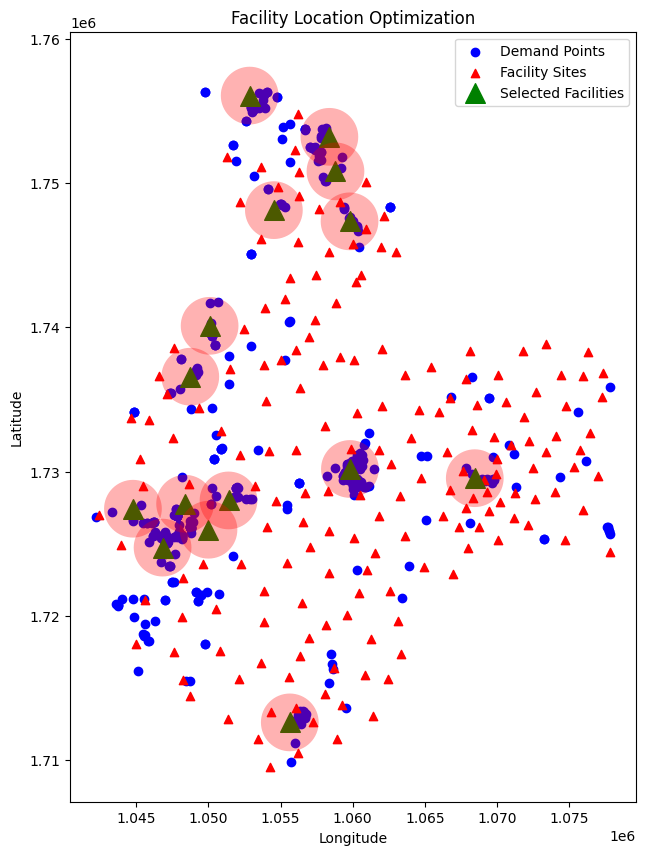

In [8]:
# 최적화 문제 정의
prob = LpProblem("Maximal_Covering_Location_Problem", LpMaximize)

# 결정 변수 정의
J = li.index.values
I = points.index.values
x = LpVariable.dicts("x", J, lowBound=0, upBound=1, cat='Integer')
y = LpVariable.dicts("y", I, lowBound=0, upBound=1, cat='Integer')

S = 1500
min_dist = 2000
a = points['weights'].values
P = 15

# N은 각 수요 지점이 커버될 수 있는 정류장의 리스트를 포함하는 리스트
N = [[j for j in J if d[i][j] < S] for i in I]
# R은 정류장 사이의 거리가 최소 거리 min_dist보다 작은지 여부를 나타내는 0과 1의 값을 가지는 리스트
R = [[int(r[li_i][li_j] < min_dist) for li_j in J] for li_i in J]

# 목적 함수 정의
prob += lpSum([a[i] * y[i] for i in I])

# 제약 조건 정의
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]
for j in J:
    prob += lpSum([x[rr] for rr in R[j]]) <= 1

prob += lpSum([x[j] for j in J]) == P

# 문제 해결
prob.solve()

x_soln = np.array([x[j].varValue for j in J])

# 결과 출력
print("Status:", LpStatus[prob.status])
print("Weight Covered is =", value(prob.objective))
print("x =", x_soln)

# 시각화
li_gdf = gpd.GeoDataFrame(li, geometry='geometry')
points_gdf = gpd.GeoDataFrame(points, geometry='geometry')

selected_lis = li_gdf.iloc[np.where(x_soln == 1)[0]] #우선 순위가 있을지?

# 좌표계가 투영된 좌표계인지 확인
if selected_lis.crs.to_string() != "EPSG:5179":
    selected_lis = selected_lis.to_crs(epsg=5179)

buffer_gdf = selected_lis.copy()
buffer_gdf['geometry'] = buffer_gdf['geometry'].buffer(2000)  # 반경 2000m
buffer_gdf.crs = selected_lis.crs

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
points_gdf.plot(ax=ax, color='blue', label='Demand Points')
li_gdf.plot(ax=ax, color='red', marker='^', label='Facility Sites')
selected_lis.plot(ax=ax, color='green', marker='^', label='Selected Facilities', markersize=200)
buffer_gdf.plot(ax=ax, color='red', alpha=0.3, label='Buffers')


plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Facility Location Optimization')
plt.show()

# 2. 지도 시각화

In [9]:
!pip install contextily
import contextily as ctx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 21.5 MB/s eta 0:00:00


In [10]:
!pip install folium
import folium
from folium.plugins import MarkerCluster

## API 사용하여 지도 적용

In [ ]:
vworld_key=" 30EC33B0-A6D2-38C3-8672-A76F64844F75"


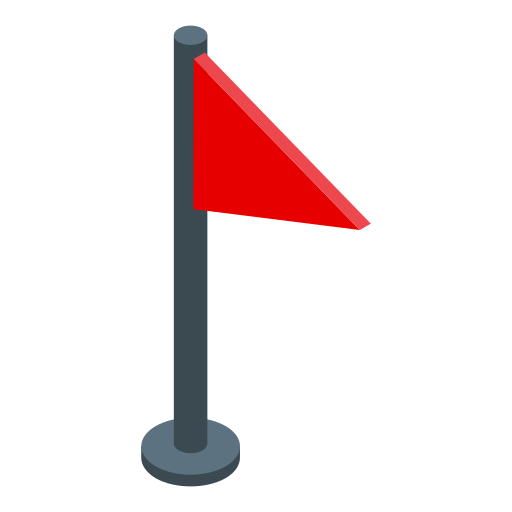
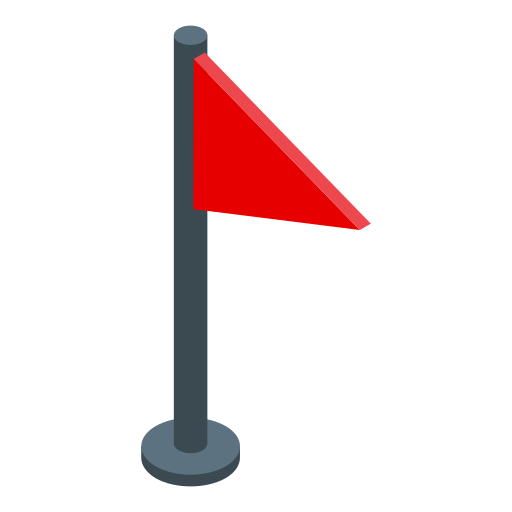
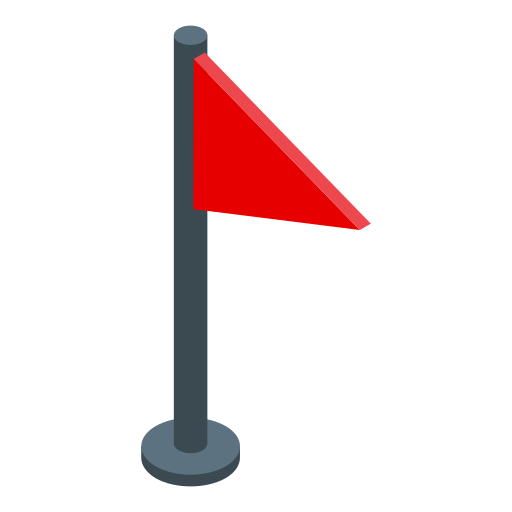
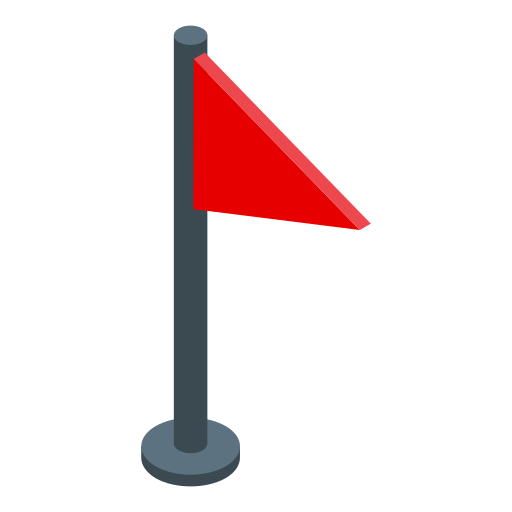
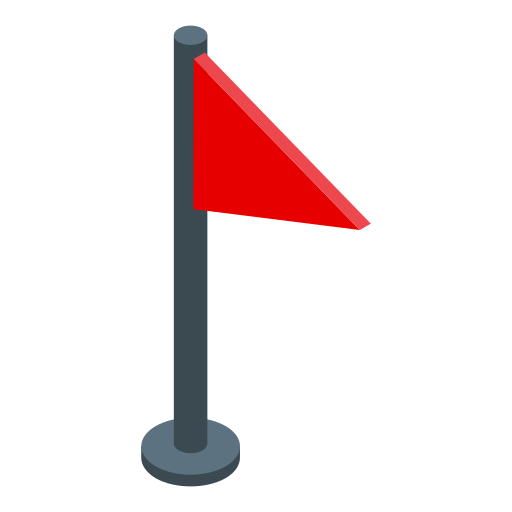
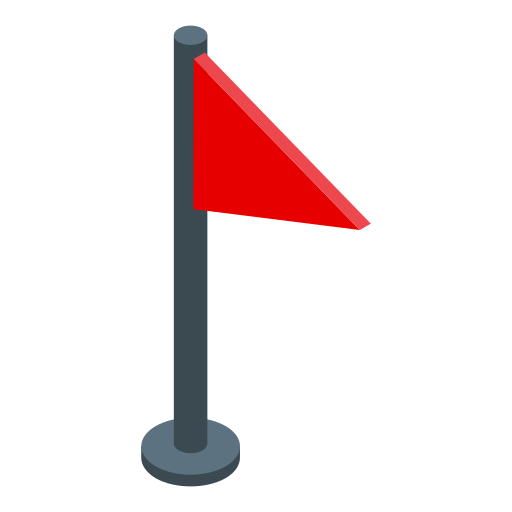
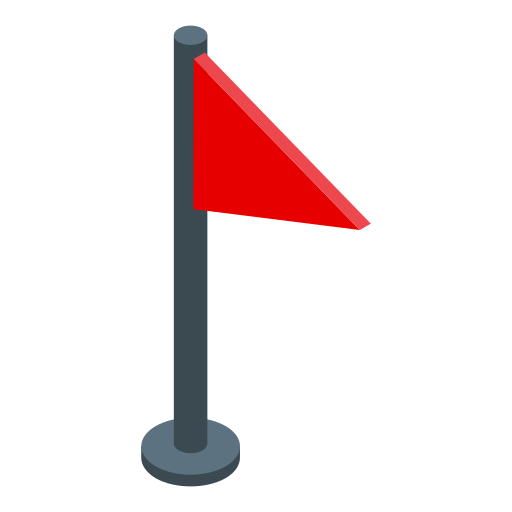
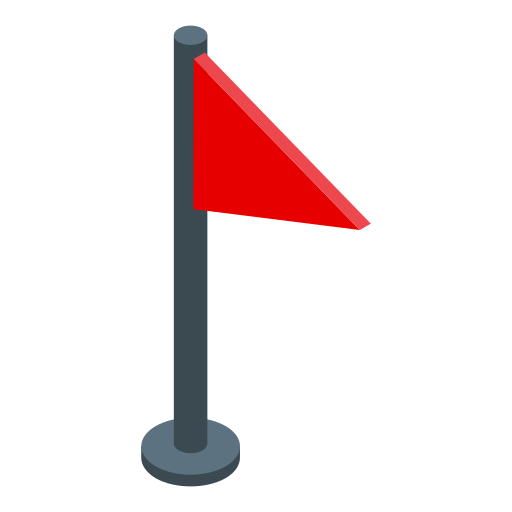
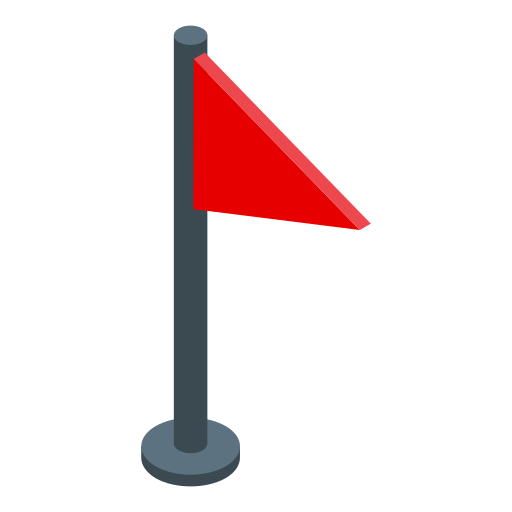
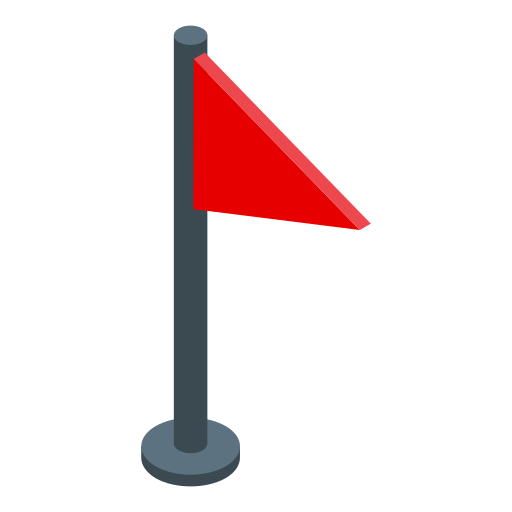
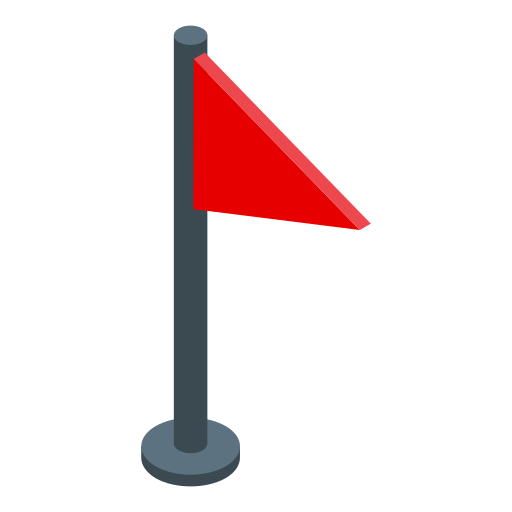
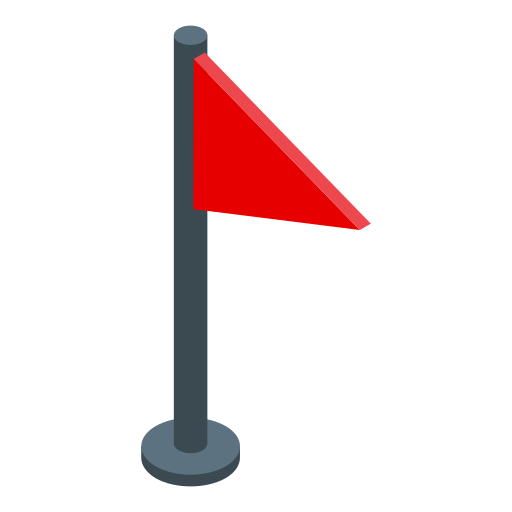
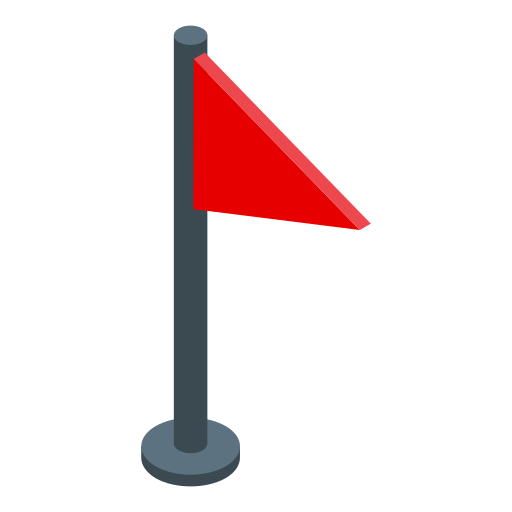
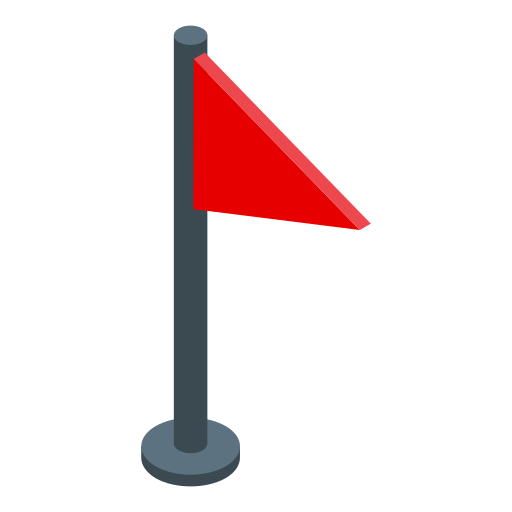
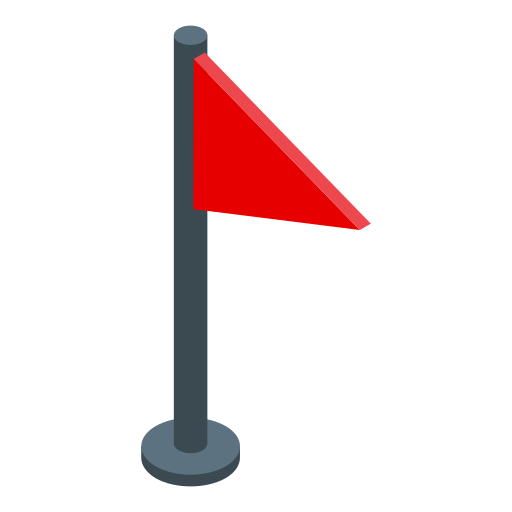

In [ ]:
# 배경지도 타일 설정하기
layer = "Base"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

m

##folium 기본 지도 사용

In [14]:
# 최종 입지 선정된 곳을 folium으로 시각화
# 좌표계를 다시 EPSG:4326으로 변환하여 folium에서 사용
uses_houses = gpd.GeoDataFrame(uses_houses, geometry=gpd.points_from_xy(uses_houses['lng'], uses_houses['lat']))
uses_houses.crs = 'epsg:4326'
sights_m = gpd.GeoDataFrame(sights_m, geometry=gpd.points_from_xy(sights_m['lng'], sights_m['lat']))
sights_m.crs = 'epsg:4326'
points_m = points.to_crs(epsg=4326)
li_m = li.to_crs(epsg=4326)
selected_lis_m = li_m.iloc[np.where(x_soln == 1)[0]]

m = folium.Map(location=[points_m.geometry.y.mean(), points_m.geometry.x.mean()], zoom_start=13)


# 사용자 정의 아이콘을 사용하여 마커 추가
home_icon_url = '/content/home.png'  # 사용자 정의 아이콘 URL (이미지 파일 경로)
home_icon_size = (14, 14)  # 아이콘 크기 조절

point_icon_url = '/content/placeholder.png'  # 사용자 정의 아이콘 URL (이미지 파일 경로)
point_icon_size = (14, 14)  # 아이콘 크기 조절

selected_lis_m_icon_url = '/content/'  # 사용자 정의 아이콘 URL (이미지 파일 경로)
selected_lis_m_icon_size = (30, 30)  # 아이콘 크기 조절

# 수요 지점 표시
# for idx, row in points_m.iterrows():
#     folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=3, color='blue', fill=True).add_to(m)

# for idx, row in points_m.iterrows(): # 사용자 아이콘 정의시
#     point_icon = folium.CustomIcon(icon_image=point_icon_url, icon_size=point_icon_size)
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=point_icon).add_to(m)

# 시설 입지 후보 지점 표시
# for idx, row in li_m.iterrows():
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=folium.Icon(color='red', icon='info-sign')).add_to(m)

# for idx, row in li_m.iterrows(): # 사용자 아이콘 정의시
#     li_icon = folium.CustomIcon(icon_image=li_icon_url, icon_size=li_icon_size)
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=li_icon).add_to(m)

# 선택된 시설 입지 지점 표시
for idx, row in selected_lis_m.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x], icon=folium.Icon(color='yellow', icon='check')).add_to(m)

# for idx, row in selected_lis_m.iterrows(): # 사용자 아이콘 정의시
#     selected_lis_m_icon = folium.CustomIcon(icon_image=selected_lis_m_icon_url, icon_size=selected_lis_m_icon_size)
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=li_icon).add_to(m)

#활용형 빈집 표시
# for idx, row in uses_houses.iterrows():
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=folium.Icon(color='purple', icon='home')).add_to(m)

# for idx, row in uses_houses.iterrows(): # 사용자 아이콘 정의시
#     home_icon = folium.CustomIcon(icon_image=home_icon_url, icon_size=home_icon_size)
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=home_icon).add_to(m)

# 관광지 표시
# for idx, row in sights_m.iterrows():
#     folium.Marker(location=[row.geometry.y, row.geometry.x], icon=folium.Icon(color='lightblue', icon='cloud')).add_to(m)


optimal_points = selected_lis_m # 첫 15개 수요 지점 선택

for idx, row in optimal_points.iterrows(): # 커버리지 시각화
    folium.Circle(
        location=[row.geometry.y, row.geometry.x],
        radius=1500,  # 반경 설정
        color='#061EFF',  # 파란색 코드
        fill=True,
        fill_opacity=0.1
    ).add_to(m)

# 지도 표시
m.save('facility_location_optimization.html')
m


<ipython-input-14-296d23b15038>:42: UserWarning: color argument of Icon should be one of: {'cadetblue', 'purple', 'blue', 'red', 'darkpurple', 'white', 'darkgreen', 'lightred', 'darkblue', 'pink', 'lightgray', 'darkred', 'lightblue', 'orange', 'gray', 'beige', 'green', 'black', 'lightgreen'}.
  folium.Marker(location=[row.geometry.y, row.geometry.x], icon=folium.Icon(color='yellow', icon='check')).add_to(m)


# 3.최적의 입지 우선순위 계산

In [12]:
# 각 선택된 시설이 커버하는 가중치를 계산
selected_lis['covered_weights'] = 0

for j in selected_lis.index:
    covered_points = points[[point.distance(selected_lis.geometry.loc[j]) < S for point in points.geometry]]
    total_weight = covered_points['weights'].sum() # 해당 수요 지점들의 가중치 합계
    selected_lis.at[j, 'covered_weights'] = total_weight

# 커버된 가중치를 기준으로 우선순위를 결정하여 정렬
selected_lis = selected_lis.sort_values(by='covered_weights', ascending=False)

selected_lis[['region', 'covered_weights']]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,region,covered_weights
191,경상남도 합천군 합천읍 합천리,116
31,경상남도 합천군 대병면 회양리,43
12,경상남도 합천군 가야면 치인리,30
78,경상남도 합천군 삼가면 소오리,24
24,경상남도 합천군 대병면 상천리,22
25,경상남도 합천군 대병면 성리,17
121,경상남도 합천군 용주면 가호리,17
8,경상남도 합천군 가야면 야천리,14
113,경상남도 합천군 야로면 매촌리,11
180,경상남도 합천군 초계면 중리,11


##최적의 입지 우선순위 시각화

In [13]:
!pip install pyproj
from pyproj import Transformer

               region        lat         lng  covered_weights
191  경상남도 합천군 합천읍 합천리  35.565872  128.159996              116
31   경상남도 합천군 대병면 회양리  35.517446  128.016463               43
12   경상남도 합천군 가야면 치인리  35.799474  128.085059               30
1등: 경상남도 합천군 합천읍 합천리, Lat: 35.5658724, Lng: 128.1599955
2등: 경상남도 합천군 대병면 회양리, Lat: 35.51744550000001, Lng: 128.0164633
3등: 경상남도 합천군 가야면 치인리, Lat: 35.7994742, Lng: 128.0850588



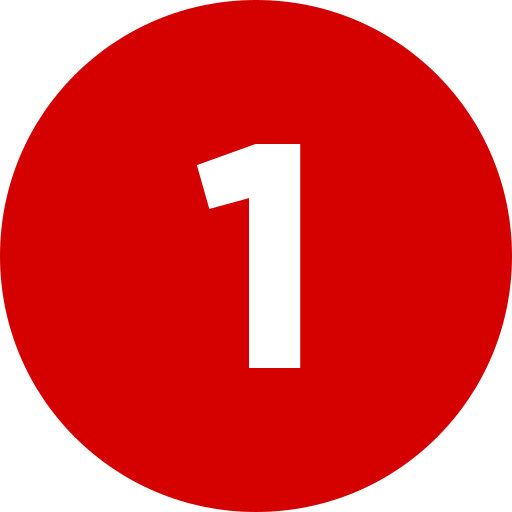
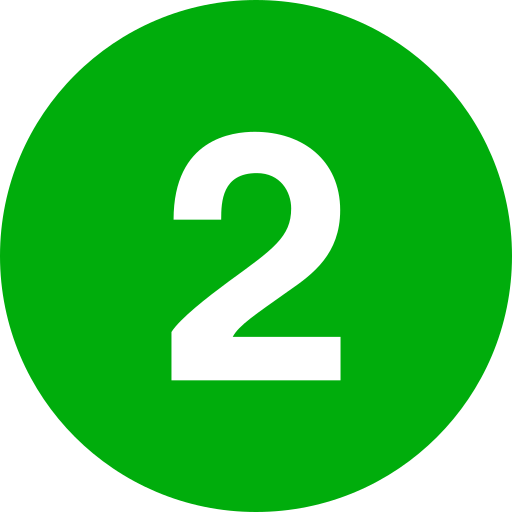
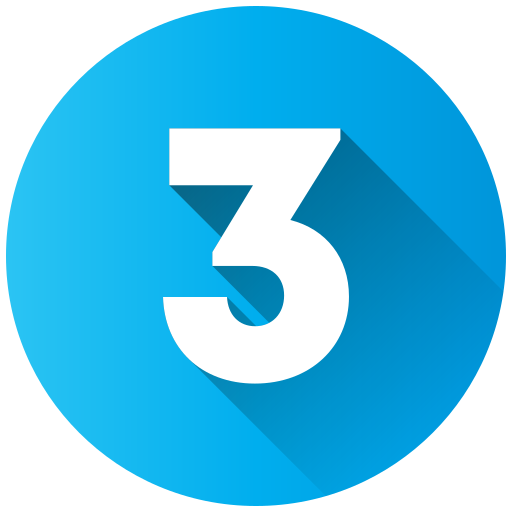

In [ ]:
# Assuming selected_lis is a GeoDataFrame with EPSG:5174 coordinates
transformer = Transformer.from_crs("epsg:5179", "epsg:4326")

# Convert coordinates from EPSG:5174 to EPSG:4326
selected_lis['lat'] = selected_lis.geometry.apply(lambda geom: transformer.transform(geom.y, geom.x)[0])
selected_lis['lng'] = selected_lis.geometry.apply(lambda geom: transformer.transform(geom.y, geom.x)[1])

# 각 선택된 시설이 커버하는 가중치를 계산
selected_lis['covered_weights'] = 0

for j in selected_lis.index:
    covered_points = points[[point.distance(selected_lis.geometry.loc[j]) < S for point in points.geometry]]
    total_weight = covered_points['weights'].sum() # 해당 수요 지점들의 가중치 합계
    selected_lis.at[j, 'covered_weights'] = total_weight


# 커버된 가중치를 기준으로 우선순위를 결정하여 정렬
selected_lis = selected_lis.sort_values(by='covered_weights', ascending=False)

# 상위 3곳만 표시
top_3 = selected_lis.head(3)

# Debug: Print the top 3 rows to check their coordinates
print(top_3[['region', 'lat', 'lng', 'covered_weights']])

# 지도 생성
center_lat = top_3['lat'].mean()
center_lng = top_3['lng'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=13)

# 사용자 정의 아이콘 URL 및 크기
first_icon_url = '/content/number-1.png'  # 1등 아이콘 이미지 파일 경로
second_icon_url = '/content/KakaoTalk_Photo_2024-07-23-14-15-06.png'  # 2등 아이콘 이미지 파일 경로
third_icon_url = '/content/number-3.png'  # 3등 아이콘 이미지 파일 경로
icon_size = (30, 30)  # 아이콘 크기 조절

# 1등 아이콘 추가
if len(top_3) > 0:
    row = top_3.iloc[0]
    print(f"1등: {row['region']}, Lat: {row['lat']}, Lng: {row['lng']}")
    first_icon = folium.CustomIcon(icon_image=first_icon_url, icon_size=icon_size)
    folium.Marker(location=[row.lat, row.lng], icon=first_icon, tooltip=f"Covered Weight: {row.covered_weights}").add_to(m)

# 2등 아이콘 추가
if len(top_3) > 1:
    row = top_3.iloc[1]
    print(f"2등: {row['region']}, Lat: {row['lat']}, Lng: {row['lng']}")
    second_icon = folium.CustomIcon(icon_image=second_icon_url, icon_size=icon_size)
    folium.Marker(location=[row.lat, row.lng], icon=second_icon, tooltip=f"Covered Weight: {row.covered_weights}").add_to(m)

# 3등 아이콘 추가
if len(top_3) > 2:
    row = top_3.iloc[2]
    print(f"3등: {row['region']}, Lat: {row['lat']}, Lng: {row['lng']}")
    third_icon = folium.CustomIcon(icon_image=third_icon_url, icon_size=icon_size)
    folium.Marker(location=[row.lat, row.lng], icon=third_icon, tooltip=f"Covered Weight: {row.covered_weights}").add_to(m)

# 지도 저장 및 표시
m.save('facility_location_top3.html')
m

## 각 시설이 커버하는 sights 지점을 추출

In [15]:
sights = sights[['이름', 'lat', 'lng']]
# GeoDataFrame으로 변환
sights = gpd.GeoDataFrame(sights, geometry=gpd.points_from_xy(sights['lng'], sights['lat']))
sights.crs = 'epsg:4326'

# 좌표계 변환
sights = sights.to_crs(epsg=5179)
sights.head()

,이름,lat,lng,geometry
0,합천영상테마파크,35.5491,128.0711,POINT (1051763.571 1728273.905)
1,해인사,35.8015,128.0987,POINT (1054094.620 1756282.580)
2,황강신소양체육공원,35.5808,128.1710,POINT (1060794.520 1731846.788)
3,천불천탑,35.4897,128.0501,POINT (1049896.894 1721675.176)
4,핫들생태공원,35.5758,128.1675,POINT (1060481.164 1731290.087)


In [16]:
# 시설로부터 일정 거리 내에 있는 sights를 찾기 위한 거리
S = 1500  # 예제에서 사용된 거리 (단위: 미터)

# 각 시설이 커버하는 sights 지점을 추출하여 데이터프레임으로 저장
results = []

for j in selected_lis.index:
    covered_sights = sights[[point.distance(selected_lis.geometry.loc[j]) < S for point in sights.geometry]]
    if covered_sights.empty:
        results.append({'facility': selected_lis.loc[j, 'region'], 'no_sights': 'No sights within 1500m'})
    else:
        covered_sights_3 = covered_sights.head(3)  # 커버된 sights 중 3개를 추출합니다.
        for _, row in covered_sights_3.iterrows():
            results.append({'facility': selected_lis.loc[j, 'region'], 'sight_name': row['이름'], 'lat': row['lat'], 'lng': row['lng']})

results_df = pd.DataFrame(results)
results_df

,facility,sight_name,lat,lng,no_sights
0,경상남도 합천군 합천읍 합천리,핫들생태공원,35.5758,128.1675,NaN
1,경상남도 합천군 합천읍 합천리,황강군민체육공원,35.5591,128.1549,NaN
2,경상남도 합천군 합천읍 합천리,합천왕후시장,35.5682,128.1603,NaN
3,경상남도 합천군 대병면 회양리,합천풀헤븐워터월드,35.5273,128.0186,NaN
4,경상남도 합천군 대병면 회양리,회양관광지,35.5242,128.0163,NaN
5,경상남도 합천군 대병면 회양리,합천호관광지체육공원/축구장,35.5217,128.0198,NaN
6,경상남도 합천군 가야면 치인리,해인사,35.8015,128.0987,NaN
7,경상남도 합천군 가야면 치인리,해인사성보박물관,35.7937,128.0946,NaN
8,경상남도 합천군 가야면 치인리,해인사원당암,35.8010,128.0926,NaN
9,경상남도 합천군 삼가면 소오리,삼가체육공원,35.4069,128.1212,NaN
